# Your DCGAN with EMD cost function

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import time
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D,Conv2DTranspose,Activation, Dense, Flatten, BatchNormalization, Dense, Dropout, Reshape
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

In [2]:
img_rows = 28
img_cols = 28
channels = 1

# Input image dimensions
img_shape = (img_rows, img_cols, channels)

# Size of the noise vector, used as input to the Generator
z_dim = 100

## Generator

In [3]:
def build_generator(z_dim):

    model = Sequential()

    # Reshape input into 7x7x256 tensor via a fully connected layer
    model.add(Dense(256 * 7 * 7, input_dim=z_dim))
    model.add(Reshape((7, 7, 256)))

    # Transposed convolution layer, from 7x7x256 into 14x14x128 tensor
    model.add(Conv2DTranspose(128, kernel_size=5, strides=2, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x128 to 14x14x64 tensor
    model.add(Conv2DTranspose(64, kernel_size=5, strides=1, padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Transposed convolution layer, from 14x14x64 to 28x28x1 tensor
    model.add(Conv2DTranspose(1, kernel_size=5, strides=2, padding='same'))

    # Output layer with tanh activation
    model.add(Activation('tanh'))

    return model

## Discriminator

In [4]:
def build_discriminator(img_shape):

    model = Sequential()

    # Convolutional layer, from 28x28x1 into 14x14x32 tensor
    model.add(
        Conv2D(32,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 14x14x32 into 7x7x64 tensor
    model.add(
        Conv2D(64,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Convolutional layer, from 7x7x64 tensor into 3x3x128 tensor
    model.add(
        Conv2D(128,
               kernel_size=3,
               strides=2,
               input_shape=img_shape,
               padding='same'))

    # Batch normalization
    model.add(BatchNormalization())

    # Leaky ReLU activation
    model.add(LeakyReLU(alpha=0.01))

    # Output layer with OUT sigmoid activation
    model.add(Flatten())
    model.add(Dense(1))

    return model

## Build the Model

In [5]:
def build_gan(generator, discriminator):

    model = Sequential()

    # Combined Generator -> Discriminator model
    model.add(generator)
    model.add(discriminator)

    return model

In [6]:
optimizer = Adam(lr=0.0002, beta_1=0.5)
bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)
def emd(a,b):
    ### YOUR CODE to get the EMD loss
    ### BEGIN
    return tf.math.reduce_mean(tf.cast(a,tf.float32)-tf.cast(b,tf.float32))
    ### END
#    return 0.

def build_models(use_tf2=False):

    # Build and compile the Discriminator
    discriminator = build_discriminator(img_shape)
    # Build the Generator
    generator = build_generator( z_dim)
    gan = build_gan(generator, discriminator)

    if use_tf2==False:
        discriminator.compile(loss=bce,
                          optimizer=optimizer,
                          metrics=['accuracy'])
        # Keep Discriminator’s parameters constant for Generator training
        discriminator.trainable = False
        # Build and compile GAN model with fixed Discriminator to train the Generator
        gan.compile(loss=bce, optimizer=optimizer)
    return discriminator, generator, gan

In [7]:
# 
def accuracy(labels, logits):
    logits=tf.concat([tf.ones_like(logits)*0.5,logits],1)
    p=tf.argmax(logits, axis=1)
    p=tf.cast(p,tf.float64)
    labels=tf.reshape(labels,[-1])
    acc=tf.reduce_sum(tf.cast(tf.equal(labels, p),tf.float64))
    return acc/logits.shape[0]

# This annotation causes the function to be "compiled".
@tf.function
def train_D(model,images, fakes):
    with tf.GradientTape() as tape:
      logits = model(images, training=True)
    ### YOUR CODE to get the loss
    ### BEGIN
      logits_fake = model(fakes, training=True)
      loss = emd(logits_fake, logits)
    ### END
    
    gradients= tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    #acc=accuracy(labels, logits)
    acc=0.0
    r_score=tf.math.reduce_mean(logits)
    f_score=tf.math.reduce_mean(logits_fake)
    return loss, r_score, f_score
@tf.function
def train_G(D_model,G_model,z, labels):
    with tf.GradientTape() as tape:
      images=G_model(z)
    ### YOUR CODE to get the loss
    ### BEGIN
      logits = D_model(images, training=True)
      loss = emd(labels, logits)
    ### END
    
    gradients= tape.gradient(loss, G_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, G_model.trainable_variables))
    return loss

In [8]:
use_tf2=True
discriminator, generator, gan = build_models(use_tf2=use_tf2)


In [9]:
generator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 12544)             1266944   
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 14, 14, 128)       819328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 128)       512       
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 64)        204864    
_________________________________________________________________
batch_normalization_3 (Batch (None, 14, 14, 64)       

## Training

In [10]:
losses = []
accuracies = []
r_accuracies = []
f_accuracies = []
r_scores = []
f_scores = []
iteration_checkpoints = []


def train(iterations, batch_size, sample_interval,use_tf2=False):

    # Load the MNIST dataset
    (X_train, _), (_, _) = mnist.load_data()

    # Rescale [0, 255] grayscale pixel values to [-1, 1]
    X_train = X_train / 127.5 - 1.0
    X_train = np.expand_dims(X_train, axis=3)

    # Labels for real images: all ones
    real = np.ones((batch_size, 1),dtype=np.float32)

    # Labels for fake images: all zeros
    fake = np.zeros((batch_size, 1),dtype=np.float32)
    start = time.time()

    for iteration in range(iterations):

        # -------------------------
        #  Train the Discriminator
        # -------------------------

        # Get a random batch of real images
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        imgs = X_train[idx]

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))
        # Train Discriminator
        gen_imgs = generator(z)
        d_loss, real_score, fake_score = train_D(discriminator,imgs, gen_imgs)

        # ---------------------
        #  Train the Generator
        # ---------------------

        # Generate a batch of fake images
        z = np.random.normal(0, 1, (batch_size, 100))

        # Train Generator
        g_loss = train_G(discriminator, generator, z, real)
        if (iteration + 1) % sample_interval == 0:

            # Save losses and accuracies so they can be plotted after training
            losses.append((d_loss, g_loss))
#            accuracies.append(100.0 * accuracy)
            r_scores.append(real_score)
            f_scores.append(fake_score)

            iteration_checkpoints.append(iteration + 1)

            # Output training progress
            print("%d [D loss: %f, real_score: %f, fake_score: %f ] [G loss: %f]" %
                  (iteration + 1, d_loss, real_score, fake_score,  g_loss))

            # Output a sample of generated image
            sample_images(generator)
            print ('Time for interval {} is {} sec'.format((iteration + 1)//sample_interval, time.time()-start))
            start = time.time()


In [11]:
def sample_images(generator, image_grid_rows=4, image_grid_columns=4):

    # Sample random noise
    z = np.random.normal(0, 1, (image_grid_rows * image_grid_columns, z_dim))

    # Generate images from random noise
    gen_imgs = generator.predict(z)

    # Rescale image pixel values to [0, 1]
    gen_imgs = 0.5 * gen_imgs + 0.5

    # Set image grid
    fig, axs = plt.subplots(image_grid_rows,
                            image_grid_columns,
                            figsize=(4, 4),
                            sharey=True,
                            sharex=True)

    cnt = 0
    for i in range(image_grid_rows):
        for j in range(image_grid_columns):
            # Output a grid of images
            axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
            axs[i, j].axis('off')
            cnt += 1
    plt.show()

## Train the GAN and Inspect Output

Note that the `'Discrepancy between trainable weights and collected trainable'` warning from Keras is expected. It is by design: The Generator's trainable parameters are intentionally held constant during Discriminator training, and vice versa.

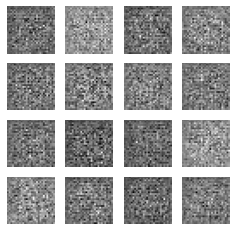

In [12]:
sample_images(generator)

100 [D loss: -13.749935, real_score: 9.579220, fake_score: -4.170715 ] [G loss: 3.136354]


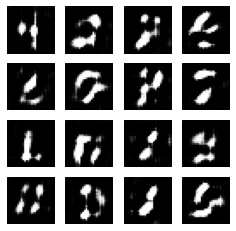

Time for interval 1 is 7.991788864135742 sec
200 [D loss: -13.561846, real_score: 12.439426, fake_score: -1.122419 ] [G loss: 9.211196]


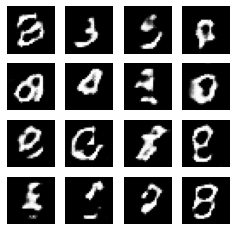

Time for interval 2 is 6.032675266265869 sec
300 [D loss: -30.580904, real_score: 23.955894, fake_score: -6.625009 ] [G loss: 18.579781]


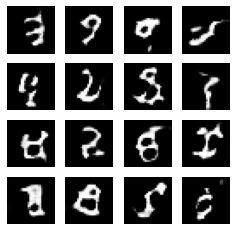

Time for interval 3 is 6.023569822311401 sec
400 [D loss: -36.526360, real_score: 23.223682, fake_score: -13.302675 ] [G loss: 22.176075]


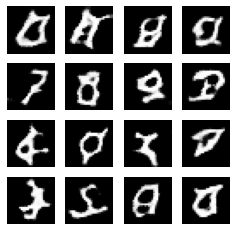

Time for interval 4 is 5.935502529144287 sec
500 [D loss: -60.030396, real_score: 28.798481, fake_score: -31.231922 ] [G loss: 48.698967]


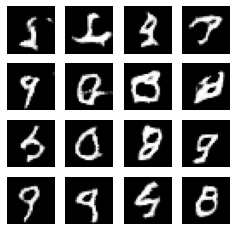

Time for interval 5 is 5.960701942443848 sec
600 [D loss: -60.598289, real_score: 32.866386, fake_score: -27.731899 ] [G loss: 29.251499]


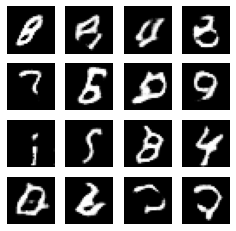

Time for interval 6 is 5.789196252822876 sec
700 [D loss: -100.366432, real_score: 49.704422, fake_score: -50.662010 ] [G loss: 70.007271]


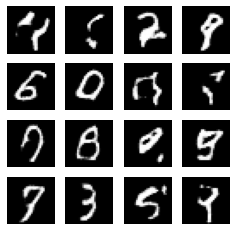

Time for interval 7 is 6.0661070346832275 sec
800 [D loss: -114.138000, real_score: 42.959816, fake_score: -71.178192 ] [G loss: 84.875702]


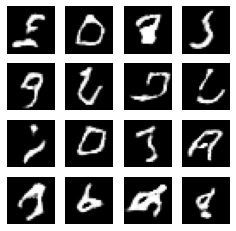

Time for interval 8 is 5.962993144989014 sec
900 [D loss: -126.738083, real_score: 59.155682, fake_score: -67.582397 ] [G loss: 58.094440]


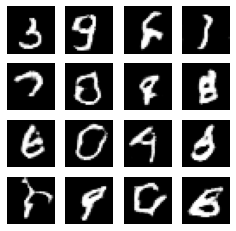

Time for interval 9 is 5.923319101333618 sec
1000 [D loss: -139.999710, real_score: 96.631531, fake_score: -43.368172 ] [G loss: 178.331711]


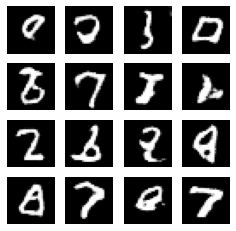

Time for interval 10 is 6.046465873718262 sec
1100 [D loss: -162.471786, real_score: 142.497864, fake_score: -19.973927 ] [G loss: 184.981262]


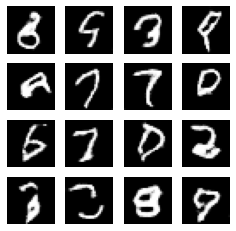

Time for interval 11 is 6.1339027881622314 sec
1200 [D loss: -167.553040, real_score: 59.505821, fake_score: -108.047226 ] [G loss: 141.744888]


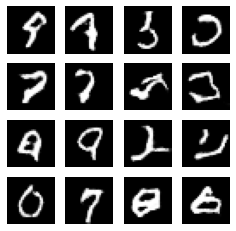

Time for interval 12 is 6.197124719619751 sec
1300 [D loss: -179.511246, real_score: 95.074760, fake_score: -84.436493 ] [G loss: 137.436737]


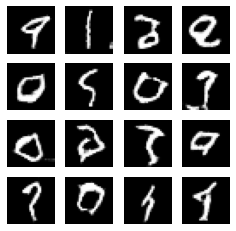

Time for interval 13 is 6.5113844871521 sec
1400 [D loss: -186.303619, real_score: 162.911346, fake_score: -23.392267 ] [G loss: 189.213989]


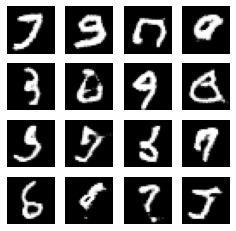

Time for interval 14 is 6.162108421325684 sec
1500 [D loss: -188.945557, real_score: 142.384644, fake_score: -46.560921 ] [G loss: 274.960999]


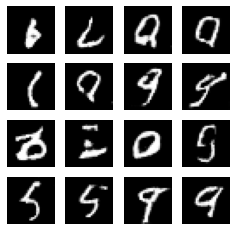

Time for interval 15 is 5.962443828582764 sec
1600 [D loss: -277.688049, real_score: 106.793175, fake_score: -170.894852 ] [G loss: 75.708115]


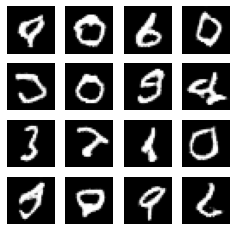

Time for interval 16 is 6.454627513885498 sec
1700 [D loss: -246.715485, real_score: 148.668671, fake_score: -98.046814 ] [G loss: 144.425079]


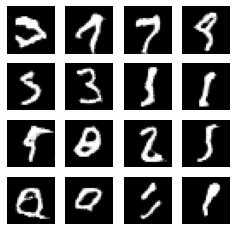

Time for interval 17 is 6.381667852401733 sec
1800 [D loss: -250.363342, real_score: 119.728020, fake_score: -130.635330 ] [G loss: 293.908203]


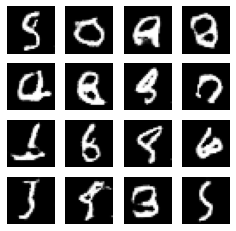

Time for interval 18 is 6.207686901092529 sec
1900 [D loss: -274.059662, real_score: 1.187735, fake_score: -272.871948 ] [G loss: 70.234947]


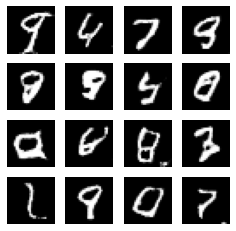

Time for interval 19 is 6.046507120132446 sec
2000 [D loss: -237.331772, real_score: 304.650391, fake_score: 67.318619 ] [G loss: 220.772034]


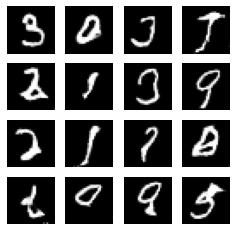

Time for interval 20 is 6.1169915199279785 sec
2100 [D loss: -299.953247, real_score: 87.061317, fake_score: -212.891953 ] [G loss: 10.483310]


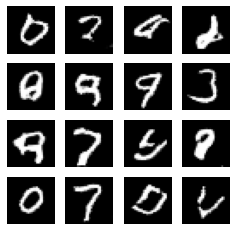

Time for interval 21 is 6.314415216445923 sec
2200 [D loss: -232.463654, real_score: 115.738136, fake_score: -116.725510 ] [G loss: 403.332855]


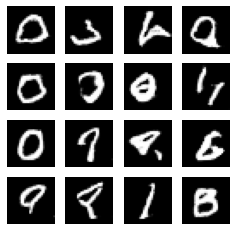

Time for interval 22 is 6.298822402954102 sec
2300 [D loss: -334.848572, real_score: -62.114052, fake_score: -396.962646 ] [G loss: 177.514267]


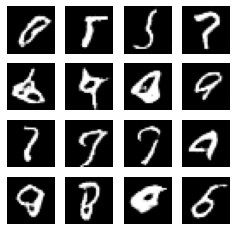

Time for interval 23 is 6.113685131072998 sec
2400 [D loss: -283.813904, real_score: -305.082550, fake_score: -588.896423 ] [G loss: 291.054993]


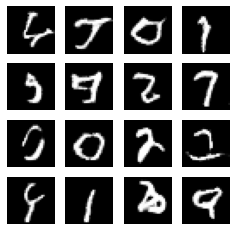

Time for interval 24 is 6.199560165405273 sec
2500 [D loss: -433.679260, real_score: 213.681427, fake_score: -219.997833 ] [G loss: 387.578003]


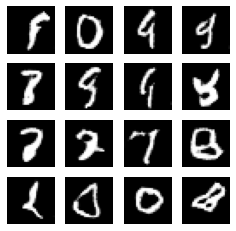

Time for interval 25 is 6.58265495300293 sec
2600 [D loss: -312.686646, real_score: -179.096252, fake_score: -491.782898 ] [G loss: 247.585205]


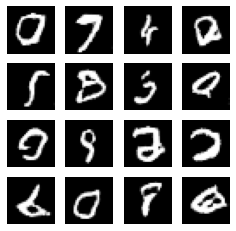

Time for interval 26 is 6.4816389083862305 sec
2700 [D loss: -379.549438, real_score: -97.860039, fake_score: -477.409485 ] [G loss: 303.011871]


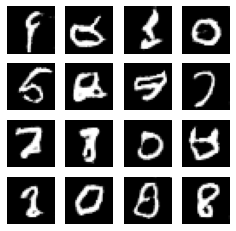

Time for interval 27 is 6.3879663944244385 sec
2800 [D loss: -354.353027, real_score: -171.245972, fake_score: -525.598999 ] [G loss: 454.931671]


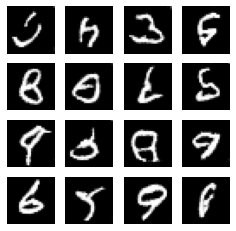

Time for interval 28 is 6.529608249664307 sec
2900 [D loss: -373.531006, real_score: -86.139397, fake_score: -459.670380 ] [G loss: 173.861267]


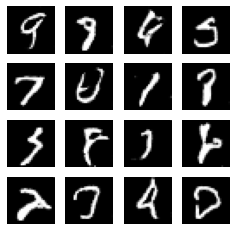

Time for interval 29 is 6.303218126296997 sec
3000 [D loss: -410.474060, real_score: 3.801723, fake_score: -406.672424 ] [G loss: 295.770172]


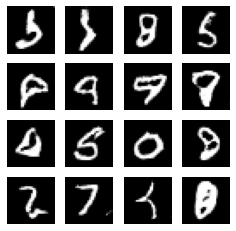

Time for interval 30 is 6.169189453125 sec
3100 [D loss: -449.207642, real_score: 488.115173, fake_score: 38.907509 ] [G loss: 278.736603]


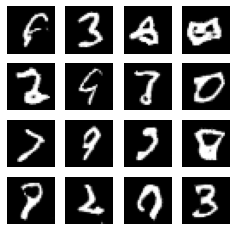

Time for interval 31 is 6.230450868606567 sec
3200 [D loss: -533.162964, real_score: 148.061401, fake_score: -385.101532 ] [G loss: 512.803345]


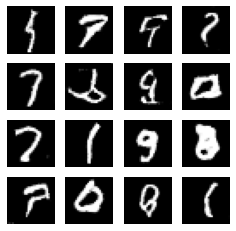

Time for interval 32 is 6.412739276885986 sec
3300 [D loss: -338.742615, real_score: 222.518707, fake_score: -116.223923 ] [G loss: 602.231812]


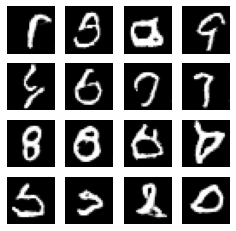

Time for interval 33 is 6.255113363265991 sec
3400 [D loss: -486.642670, real_score: 16.414879, fake_score: -470.227783 ] [G loss: 388.028564]


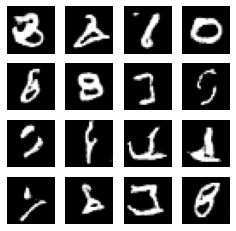

Time for interval 34 is 6.161244869232178 sec
3500 [D loss: -441.881470, real_score: 453.319427, fake_score: 11.437943 ] [G loss: 525.948181]


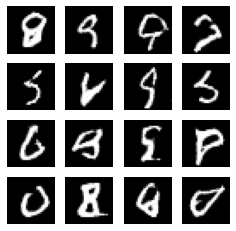

Time for interval 35 is 6.4158244132995605 sec
3600 [D loss: -510.086731, real_score: 397.600250, fake_score: -112.486504 ] [G loss: 529.004456]


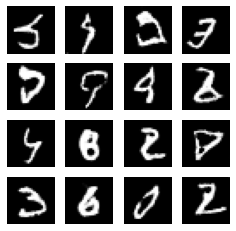

Time for interval 36 is 6.216344594955444 sec
3700 [D loss: -519.779419, real_score: 196.354919, fake_score: -323.424530 ] [G loss: 6.705465]


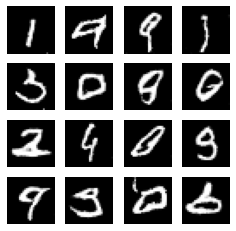

Time for interval 37 is 5.984314203262329 sec
3800 [D loss: -621.590942, real_score: -5.652771, fake_score: -627.243774 ] [G loss: 134.742935]


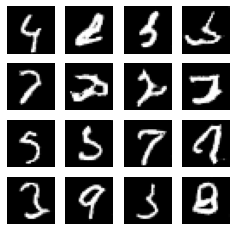

Time for interval 38 is 6.135298490524292 sec
3900 [D loss: -600.878723, real_score: 66.092308, fake_score: -534.786377 ] [G loss: 173.558044]


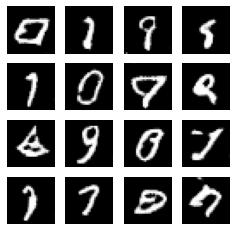

Time for interval 39 is 6.29780387878418 sec
4000 [D loss: -746.277588, real_score: 331.635406, fake_score: -414.642181 ] [G loss: 861.766113]


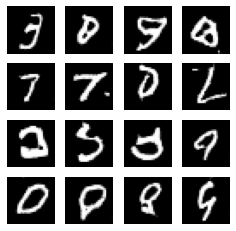

Time for interval 40 is 6.056099891662598 sec
4100 [D loss: -648.879883, real_score: 340.927673, fake_score: -307.952240 ] [G loss: 749.641113]


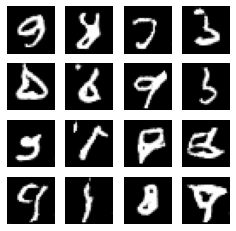

Time for interval 41 is 6.059232950210571 sec
4200 [D loss: -497.536133, real_score: 197.544373, fake_score: -299.991791 ] [G loss: 843.553772]


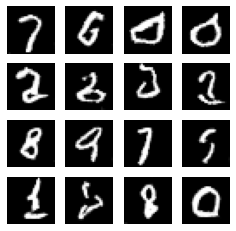

Time for interval 42 is 6.32245659828186 sec
4300 [D loss: -585.458374, real_score: 205.645370, fake_score: -379.812958 ] [G loss: 620.405518]


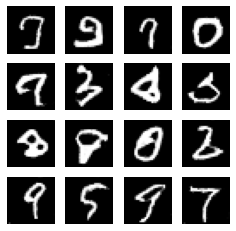

Time for interval 43 is 6.0210630893707275 sec
4400 [D loss: -579.447021, real_score: 629.599976, fake_score: 50.152916 ] [G loss: 1010.834045]


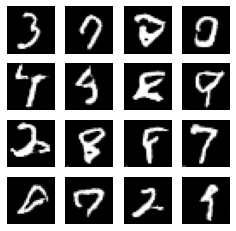

Time for interval 44 is 6.260158538818359 sec
4500 [D loss: -726.680786, real_score: 651.481140, fake_score: -75.199715 ] [G loss: 530.211609]


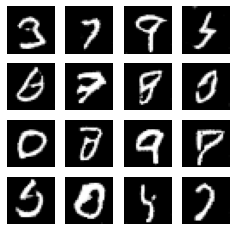

Time for interval 45 is 6.325784683227539 sec
4600 [D loss: -648.391235, real_score: -406.582764, fake_score: -1054.973999 ] [G loss: 703.194702]


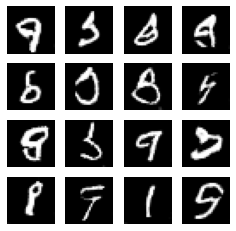

Time for interval 46 is 6.315675497055054 sec
4700 [D loss: -438.472229, real_score: -217.548157, fake_score: -656.020386 ] [G loss: 416.683929]


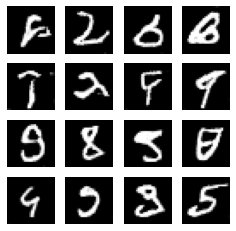

Time for interval 47 is 6.266027450561523 sec
4800 [D loss: -811.640808, real_score: 196.282379, fake_score: -615.358398 ] [G loss: 695.189392]


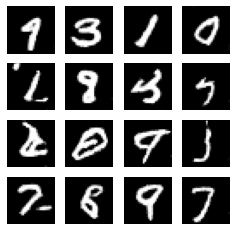

Time for interval 48 is 6.197505474090576 sec
4900 [D loss: -898.186523, real_score: -169.093643, fake_score: -1067.280151 ] [G loss: 84.040764]


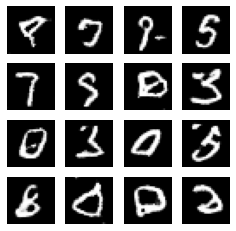

Time for interval 49 is 6.057247161865234 sec
5000 [D loss: -460.196289, real_score: -727.830688, fake_score: -1188.026978 ] [G loss: 616.216736]


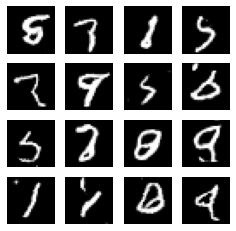

Time for interval 50 is 6.127070426940918 sec
5100 [D loss: -785.740234, real_score: -5.838577, fake_score: -791.578857 ] [G loss: 863.456665]


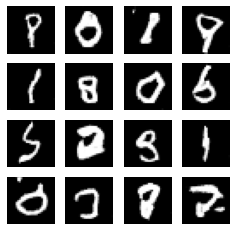

Time for interval 51 is 6.16499137878418 sec
5200 [D loss: -736.925232, real_score: 319.894409, fake_score: -417.030823 ] [G loss: 724.112732]


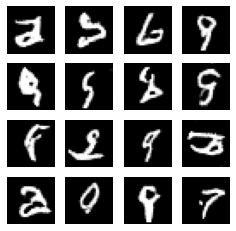

Time for interval 52 is 6.067262172698975 sec
5300 [D loss: -479.594238, real_score: 896.690613, fake_score: 417.096375 ] [G loss: 494.235260]


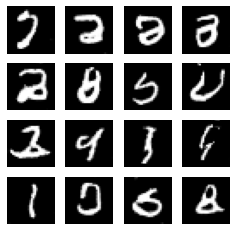

Time for interval 53 is 6.201600551605225 sec
5400 [D loss: -854.014771, real_score: 463.388916, fake_score: -390.625824 ] [G loss: 750.800171]


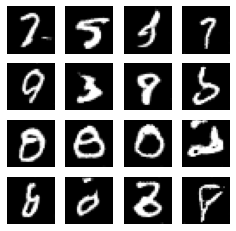

Time for interval 54 is 6.190899133682251 sec
5500 [D loss: -593.006104, real_score: -424.977570, fake_score: -1017.983704 ] [G loss: 1570.206177]


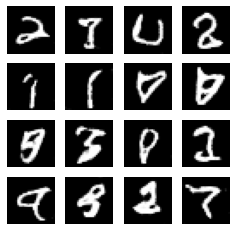

Time for interval 55 is 6.150712728500366 sec
5600 [D loss: -386.422424, real_score: 626.693359, fake_score: 240.270889 ] [G loss: 40.785885]


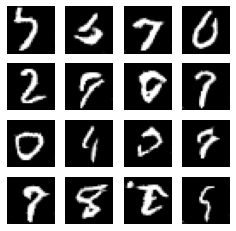

Time for interval 56 is 6.062612771987915 sec
5700 [D loss: -787.379883, real_score: -326.592743, fake_score: -1113.972656 ] [G loss: -198.788666]


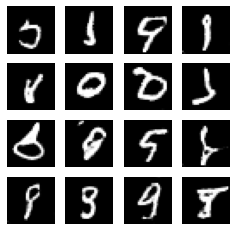

Time for interval 57 is 6.1131367683410645 sec
5800 [D loss: -737.810852, real_score: -135.653809, fake_score: -873.464661 ] [G loss: 1276.618530]


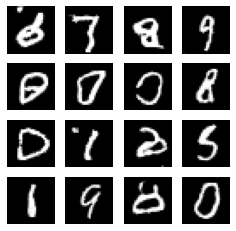

Time for interval 58 is 6.209890842437744 sec
5900 [D loss: -585.087891, real_score: 965.850525, fake_score: 380.762726 ] [G loss: 275.884308]


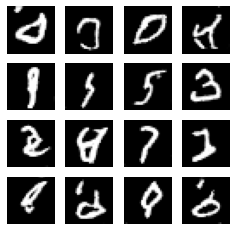

Time for interval 59 is 6.18449592590332 sec
6000 [D loss: -767.691589, real_score: 116.903610, fake_score: -650.787964 ] [G loss: 884.157227]


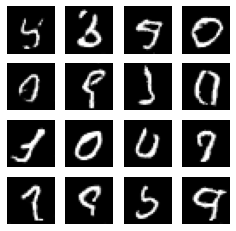

Time for interval 60 is 6.14217209815979 sec
6100 [D loss: -928.954102, real_score: -128.482300, fake_score: -1057.436401 ] [G loss: 26.667610]


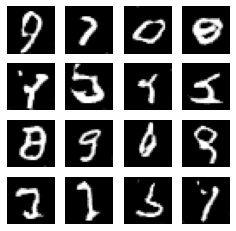

Time for interval 61 is 6.138573408126831 sec
6200 [D loss: -1129.608154, real_score: 744.325256, fake_score: -385.282837 ] [G loss: 1411.376831]


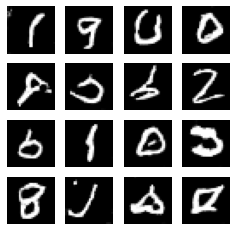

Time for interval 62 is 6.3005499839782715 sec
6300 [D loss: -1200.358032, real_score: 847.099609, fake_score: -353.258423 ] [G loss: 828.945923]


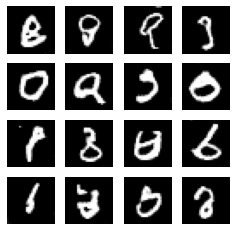

Time for interval 63 is 6.105033874511719 sec
6400 [D loss: -1038.441040, real_score: 136.548920, fake_score: -901.892151 ] [G loss: 1297.637329]


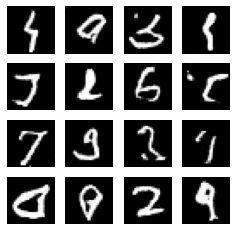

Time for interval 64 is 6.137072563171387 sec
6500 [D loss: -926.663147, real_score: 913.252991, fake_score: -13.410179 ] [G loss: 865.847778]


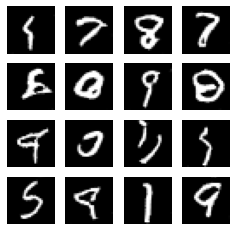

Time for interval 65 is 6.212810277938843 sec
6600 [D loss: -1095.968506, real_score: 152.577362, fake_score: -943.391174 ] [G loss: 1391.260986]


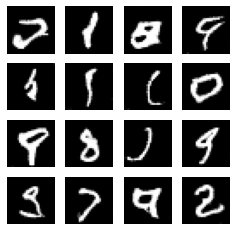

Time for interval 66 is 6.420483589172363 sec
6700 [D loss: -993.909790, real_score: 91.047890, fake_score: -902.861938 ] [G loss: 1591.782837]


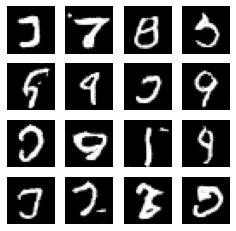

Time for interval 67 is 6.337064266204834 sec
6800 [D loss: -930.259216, real_score: 702.045288, fake_score: -228.213943 ] [G loss: 1237.744385]


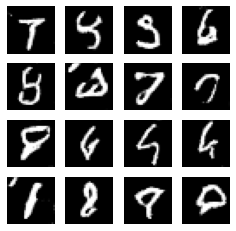

Time for interval 68 is 6.299530982971191 sec
6900 [D loss: -705.749329, real_score: 864.815247, fake_score: 159.065887 ] [G loss: 1276.068481]


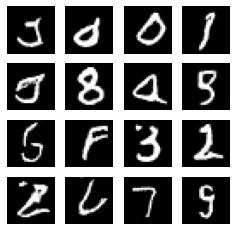

Time for interval 69 is 6.169472932815552 sec
7000 [D loss: -959.351990, real_score: -870.412354, fake_score: -1829.764404 ] [G loss: 1196.261719]


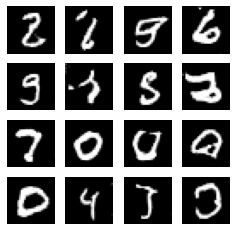

Time for interval 70 is 6.1225426197052 sec
7100 [D loss: -1450.217773, real_score: 668.390198, fake_score: -781.827515 ] [G loss: 1028.960571]


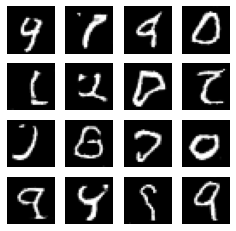

Time for interval 71 is 6.189372301101685 sec
7200 [D loss: -1026.495361, real_score: -464.136810, fake_score: -1490.632324 ] [G loss: 1969.050049]


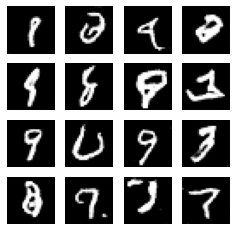

Time for interval 72 is 6.422232389450073 sec
7300 [D loss: -1275.101562, real_score: 233.462860, fake_score: -1041.638672 ] [G loss: 1643.750000]


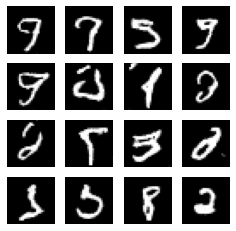

Time for interval 73 is 6.182100772857666 sec
7400 [D loss: -778.973999, real_score: 1049.182007, fake_score: 270.207947 ] [G loss: 1128.621338]


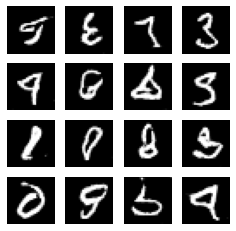

Time for interval 74 is 6.359221935272217 sec
7500 [D loss: -1069.941895, real_score: 599.682983, fake_score: -470.258911 ] [G loss: 684.359070]


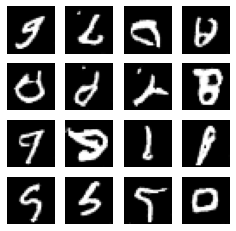

Time for interval 75 is 6.121615648269653 sec
7600 [D loss: -885.179688, real_score: 530.155884, fake_score: -355.023804 ] [G loss: 574.230103]


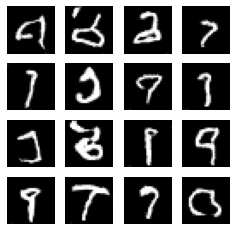

Time for interval 76 is 6.217396020889282 sec
7700 [D loss: -891.134644, real_score: -313.268066, fake_score: -1204.402710 ] [G loss: 372.515137]


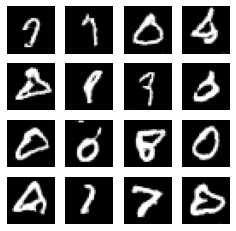

Time for interval 77 is 6.163079261779785 sec
7800 [D loss: -663.214844, real_score: -486.682312, fake_score: -1149.897217 ] [G loss: 456.283569]


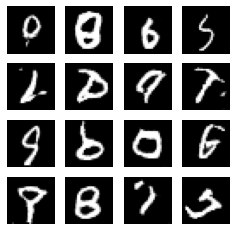

Time for interval 78 is 6.119304418563843 sec
7900 [D loss: -715.563843, real_score: 238.709961, fake_score: -476.853851 ] [G loss: 1196.035645]


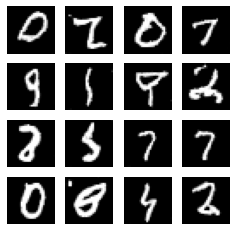

Time for interval 79 is 6.283239841461182 sec
8000 [D loss: -1369.372314, real_score: 323.111145, fake_score: -1046.261230 ] [G loss: 700.633850]


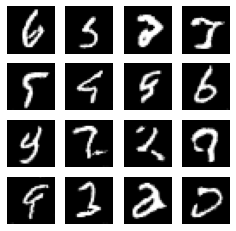

Time for interval 80 is 6.087488412857056 sec
8100 [D loss: -1070.984619, real_score: 1731.082764, fake_score: 660.098022 ] [G loss: 543.943604]


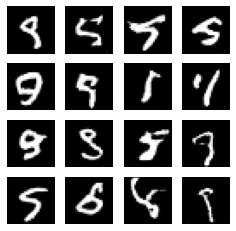

Time for interval 81 is 6.090162754058838 sec
8200 [D loss: -1037.756104, real_score: -1077.164307, fake_score: -2114.920410 ] [G loss: 361.023560]


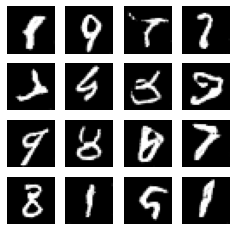

Time for interval 82 is 6.095913887023926 sec
8300 [D loss: -1096.922729, real_score: 329.002502, fake_score: -767.920288 ] [G loss: 795.155029]


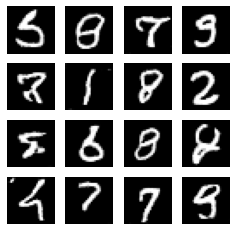

Time for interval 83 is 6.139136791229248 sec
8400 [D loss: -1239.441406, real_score: -365.530396, fake_score: -1604.971924 ] [G loss: 1718.976562]


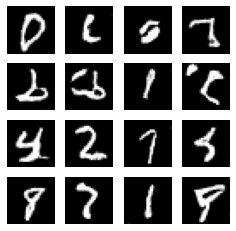

Time for interval 84 is 6.099616289138794 sec
8500 [D loss: -812.996094, real_score: -238.817123, fake_score: -1051.813232 ] [G loss: 2044.649414]


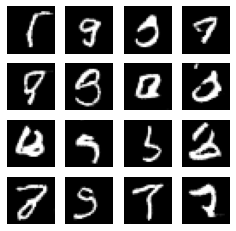

Time for interval 85 is 6.057974576950073 sec
8600 [D loss: -1605.174561, real_score: 1074.598999, fake_score: -530.575562 ] [G loss: 657.568359]


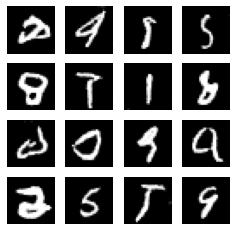

Time for interval 86 is 6.338946580886841 sec
8700 [D loss: -1787.803711, real_score: -447.924805, fake_score: -2235.728516 ] [G loss: 1114.712280]


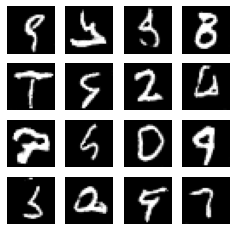

Time for interval 87 is 6.1408467292785645 sec
8800 [D loss: -1262.994629, real_score: -515.044922, fake_score: -1778.039551 ] [G loss: 371.668121]


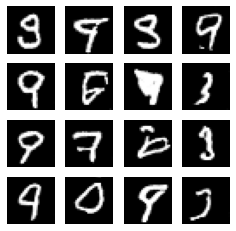

Time for interval 88 is 6.315304517745972 sec
8900 [D loss: -1491.481445, real_score: -239.928116, fake_score: -1731.409546 ] [G loss: -138.050537]


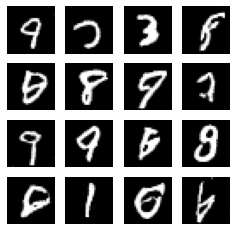

Time for interval 89 is 6.098674535751343 sec
9000 [D loss: -359.783203, real_score: 798.520935, fake_score: 438.737671 ] [G loss: 869.477600]


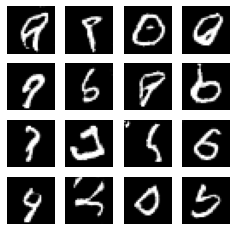

Time for interval 90 is 6.415817975997925 sec
9100 [D loss: -1505.738403, real_score: -950.860291, fake_score: -2456.598633 ] [G loss: 814.669067]


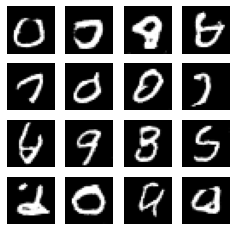

Time for interval 91 is 6.1015589237213135 sec
9200 [D loss: -1641.305420, real_score: 1152.471191, fake_score: -488.834198 ] [G loss: 1250.928223]


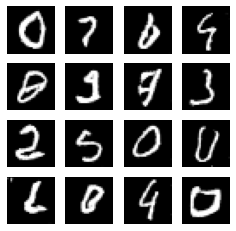

Time for interval 92 is 6.103061199188232 sec
9300 [D loss: -950.560791, real_score: 913.512146, fake_score: -37.048637 ] [G loss: 1322.159668]


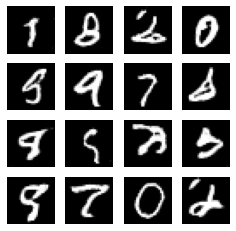

Time for interval 93 is 6.3414905071258545 sec
9400 [D loss: -1744.153564, real_score: -1319.930176, fake_score: -3064.083740 ] [G loss: -668.358154]


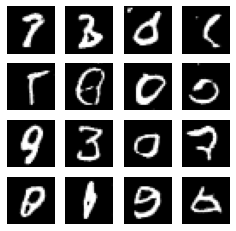

Time for interval 94 is 6.164618968963623 sec
9500 [D loss: -1053.542603, real_score: -147.209015, fake_score: -1200.751709 ] [G loss: 532.394531]


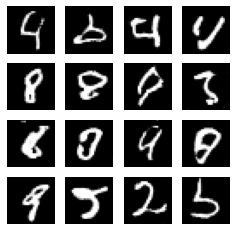

Time for interval 95 is 6.1442272663116455 sec
9600 [D loss: -1503.967896, real_score: 262.619049, fake_score: -1241.348633 ] [G loss: 118.380112]


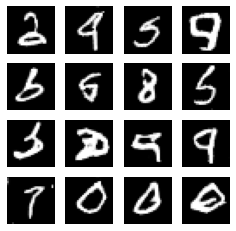

Time for interval 96 is 6.310167074203491 sec
9700 [D loss: -1508.516602, real_score: -1135.460327, fake_score: -2643.976807 ] [G loss: 1624.501587]


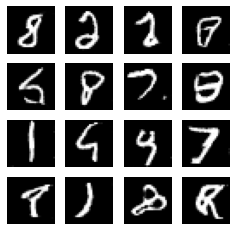

Time for interval 97 is 6.245213747024536 sec
9800 [D loss: -926.800049, real_score: 650.483887, fake_score: -276.316254 ] [G loss: 726.788818]


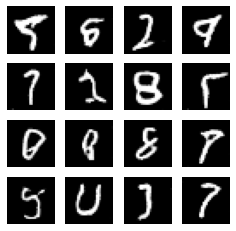

Time for interval 98 is 6.375416278839111 sec
9900 [D loss: -2059.523193, real_score: 837.305237, fake_score: -1222.217896 ] [G loss: 1813.196533]


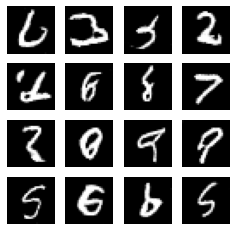

Time for interval 99 is 6.157713413238525 sec
10000 [D loss: -1075.925171, real_score: 789.547363, fake_score: -286.377747 ] [G loss: 1962.366211]


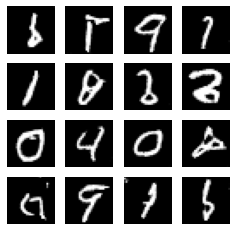

Time for interval 100 is 6.194671392440796 sec
10100 [D loss: -1147.101562, real_score: -534.767456, fake_score: -1681.868896 ] [G loss: 722.696899]


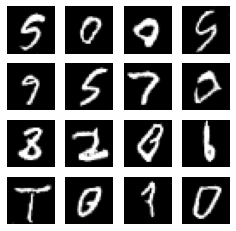

Time for interval 101 is 6.093293190002441 sec
10200 [D loss: -1393.864990, real_score: -661.328857, fake_score: -2055.193848 ] [G loss: 1351.276245]


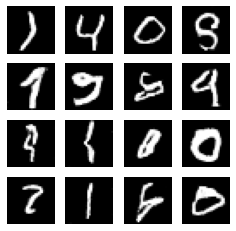

Time for interval 102 is 6.144111156463623 sec
10300 [D loss: -1205.221924, real_score: 6.560707, fake_score: -1198.661255 ] [G loss: 976.356445]


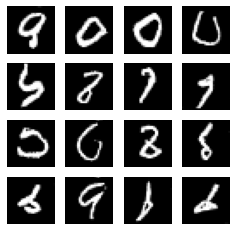

Time for interval 103 is 6.1012890338897705 sec
10400 [D loss: -1785.770142, real_score: 2300.767090, fake_score: 514.996826 ] [G loss: 1085.920166]


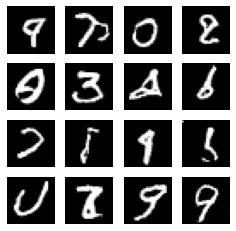

Time for interval 104 is 6.310803174972534 sec
10500 [D loss: -2272.525879, real_score: -218.478134, fake_score: -2491.004150 ] [G loss: 617.716492]


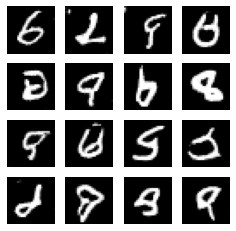

Time for interval 105 is 6.271114110946655 sec
10600 [D loss: -2578.353271, real_score: 1572.764893, fake_score: -1005.588318 ] [G loss: 1113.513306]


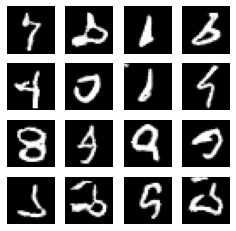

Time for interval 106 is 6.095546245574951 sec
10700 [D loss: -815.145508, real_score: -1717.719482, fake_score: -2532.865234 ] [G loss: 3771.981689]


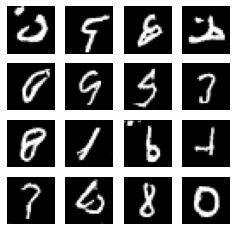

Time for interval 107 is 6.175114393234253 sec
10800 [D loss: -2237.256592, real_score: -125.357910, fake_score: -2362.614502 ] [G loss: 802.391235]


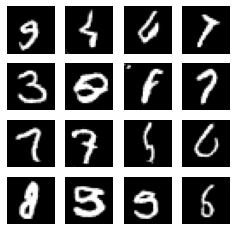

Time for interval 108 is 6.122625827789307 sec
10900 [D loss: -1798.104736, real_score: 1331.020508, fake_score: -467.084381 ] [G loss: 2414.070801]


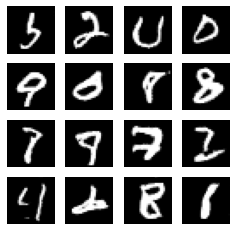

Time for interval 109 is 6.129858016967773 sec
11000 [D loss: -865.062012, real_score: 585.132019, fake_score: -279.929993 ] [G loss: 3815.557617]


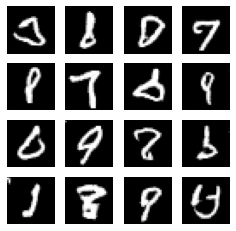

Time for interval 110 is 6.125520467758179 sec
11100 [D loss: -1820.216309, real_score: 514.978943, fake_score: -1305.237305 ] [G loss: 978.505493]


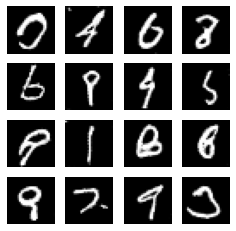

Time for interval 111 is 6.216820955276489 sec
11200 [D loss: -2287.398438, real_score: 904.536377, fake_score: -1382.862061 ] [G loss: 1734.801758]


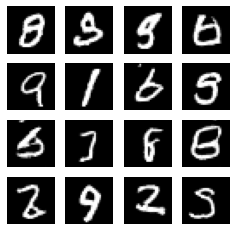

Time for interval 112 is 6.341207981109619 sec
11300 [D loss: -2565.642090, real_score: 1352.294067, fake_score: -1213.347900 ] [G loss: 2928.275879]


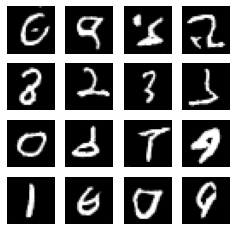

Time for interval 113 is 6.0274529457092285 sec
11400 [D loss: -1538.176880, real_score: -876.489868, fake_score: -2414.666748 ] [G loss: 1367.198975]


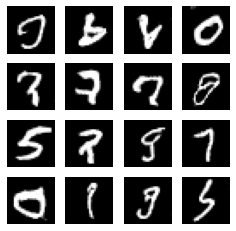

Time for interval 114 is 6.2790868282318115 sec
11500 [D loss: -1458.411133, real_score: 290.061920, fake_score: -1168.349121 ] [G loss: 1566.753662]


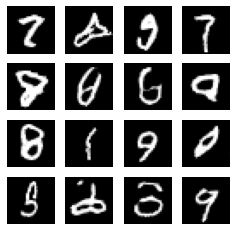

Time for interval 115 is 6.1423139572143555 sec
11600 [D loss: -1098.417725, real_score: -118.375748, fake_score: -1216.793335 ] [G loss: 3887.556152]


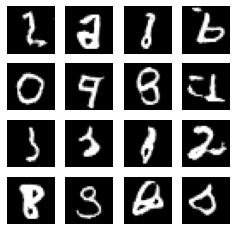

Time for interval 116 is 6.253643989562988 sec
11700 [D loss: -1607.439453, real_score: -417.556213, fake_score: -2024.995850 ] [G loss: 1549.516724]


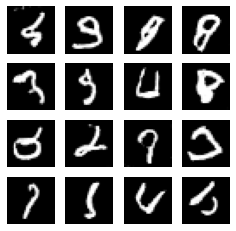

Time for interval 117 is 6.21042275428772 sec
11800 [D loss: -1313.608643, real_score: -554.091980, fake_score: -1867.700684 ] [G loss: 1590.036987]


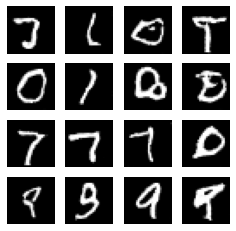

Time for interval 118 is 6.254408359527588 sec
11900 [D loss: -1969.408691, real_score: 546.819946, fake_score: -1422.588867 ] [G loss: 2919.811279]


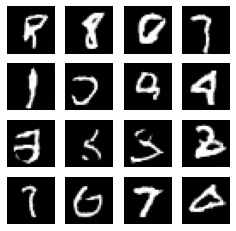

Time for interval 119 is 6.1622138023376465 sec
12000 [D loss: -1843.479370, real_score: -2061.798340, fake_score: -3905.277832 ] [G loss: 1685.986694]


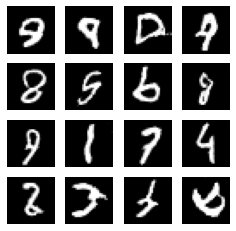

Time for interval 120 is 6.109116077423096 sec
12100 [D loss: -1346.597656, real_score: 946.873047, fake_score: -399.724609 ] [G loss: 1166.271484]


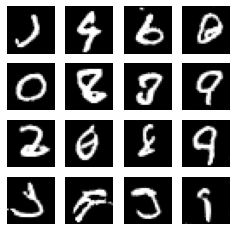

Time for interval 121 is 6.608222007751465 sec
12200 [D loss: -2034.883301, real_score: 1988.863770, fake_score: -46.019394 ] [G loss: -64.195877]


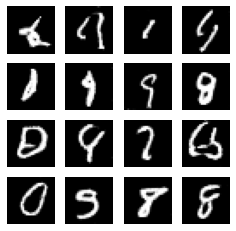

Time for interval 122 is 6.327736854553223 sec
12300 [D loss: -1512.329712, real_score: 772.286255, fake_score: -740.043518 ] [G loss: 3923.443604]


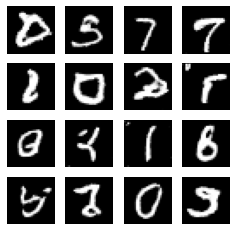

Time for interval 123 is 6.105912923812866 sec
12400 [D loss: -1594.598145, real_score: 797.183472, fake_score: -797.414673 ] [G loss: 3541.802002]


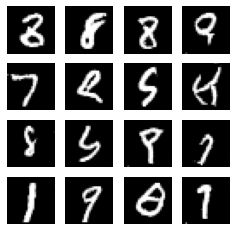

Time for interval 124 is 6.115983009338379 sec
12500 [D loss: -3114.233398, real_score: 2188.770020, fake_score: -925.463318 ] [G loss: 3470.463379]


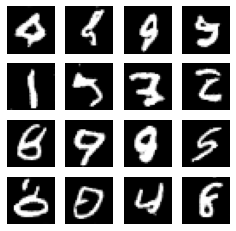

Time for interval 125 is 6.507920980453491 sec
12600 [D loss: -2692.681885, real_score: 2865.704590, fake_score: 173.022568 ] [G loss: 1738.181152]


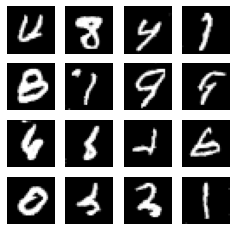

Time for interval 126 is 6.091805934906006 sec
12700 [D loss: -1533.727295, real_score: 1191.996338, fake_score: -341.731018 ] [G loss: -22.419388]


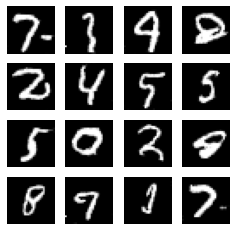

Time for interval 127 is 6.159369707107544 sec
12800 [D loss: -2068.607910, real_score: 444.571777, fake_score: -1624.036133 ] [G loss: 2252.972656]


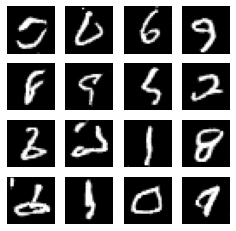

Time for interval 128 is 6.1562581062316895 sec
12900 [D loss: -2466.049316, real_score: 1757.723389, fake_score: -708.326111 ] [G loss: 1161.042603]


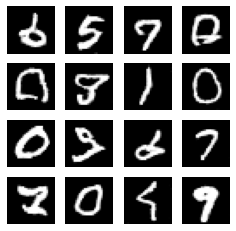

Time for interval 129 is 6.165592670440674 sec
13000 [D loss: -1651.627441, real_score: -133.684479, fake_score: -1785.311890 ] [G loss: 757.410889]


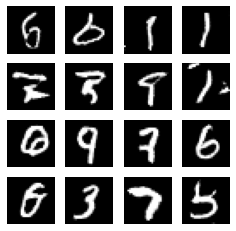

Time for interval 130 is 6.2906718254089355 sec
13100 [D loss: -1721.623047, real_score: 1374.018066, fake_score: -347.604950 ] [G loss: 1579.145142]


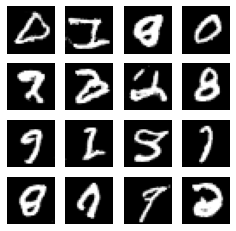

Time for interval 131 is 6.126925706863403 sec
13200 [D loss: -3129.690430, real_score: 2267.341797, fake_score: -862.348633 ] [G loss: 3424.214355]


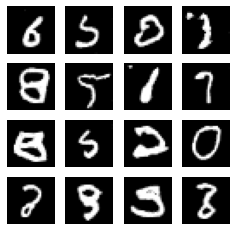

Time for interval 132 is 6.2551069259643555 sec
13300 [D loss: -2251.388916, real_score: -2248.554199, fake_score: -4499.942871 ] [G loss: 4156.333008]


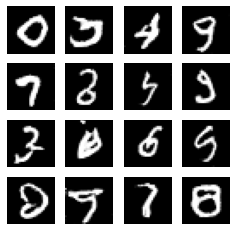

Time for interval 133 is 6.07804274559021 sec
13400 [D loss: -2285.093750, real_score: 2065.290527, fake_score: -219.803192 ] [G loss: 3547.029297]


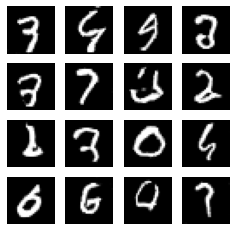

Time for interval 134 is 6.1635353565216064 sec
13500 [D loss: -2404.445801, real_score: 511.348816, fake_score: -1893.096924 ] [G loss: 2195.714355]


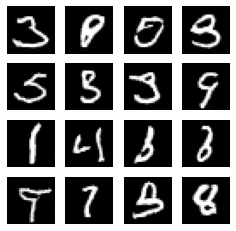

Time for interval 135 is 6.226779222488403 sec
13600 [D loss: -1285.758545, real_score: -129.188690, fake_score: -1414.947266 ] [G loss: 3221.071289]


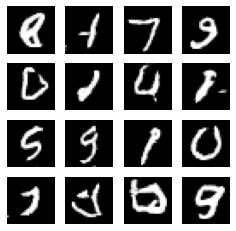

Time for interval 136 is 6.06479811668396 sec
13700 [D loss: -2379.807373, real_score: -1552.322266, fake_score: -3932.129883 ] [G loss: 1998.600464]


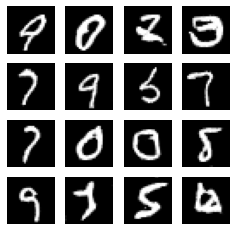

Time for interval 137 is 6.134901523590088 sec
13800 [D loss: -2516.854980, real_score: -1027.375244, fake_score: -3544.229980 ] [G loss: 4120.485352]


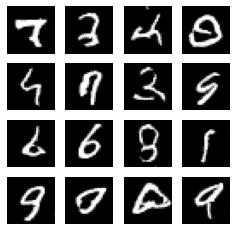

Time for interval 138 is 6.417116641998291 sec
13900 [D loss: -1608.879395, real_score: 91.896980, fake_score: -1516.982422 ] [G loss: 1747.391846]


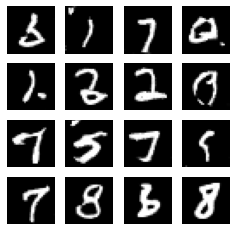

Time for interval 139 is 6.3831422328948975 sec
14000 [D loss: -2493.532471, real_score: 947.833862, fake_score: -1545.698242 ] [G loss: 4380.684570]


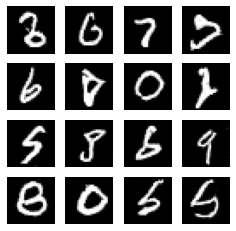

Time for interval 140 is 6.042893886566162 sec
14100 [D loss: -1470.489380, real_score: -507.125824, fake_score: -1977.615356 ] [G loss: 3145.059326]


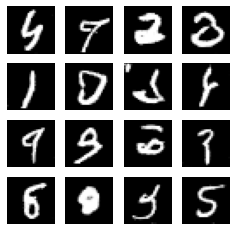

Time for interval 141 is 6.09837532043457 sec
14200 [D loss: -2901.045410, real_score: -235.878067, fake_score: -3136.923340 ] [G loss: 2321.410400]


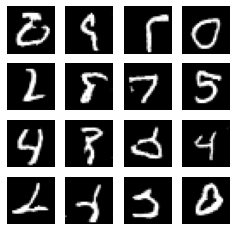

Time for interval 142 is 6.231112241744995 sec
14300 [D loss: -2172.452148, real_score: 564.460693, fake_score: -1607.991577 ] [G loss: 2785.766602]


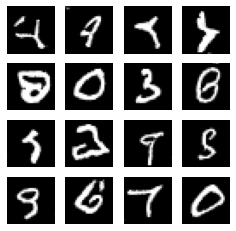

Time for interval 143 is 6.210599660873413 sec
14400 [D loss: -1749.695923, real_score: -1885.394775, fake_score: -3635.090820 ] [G loss: 3811.129639]


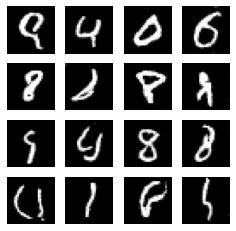

Time for interval 144 is 6.158818483352661 sec
14500 [D loss: -3030.361816, real_score: -165.923553, fake_score: -3196.285156 ] [G loss: 852.321289]


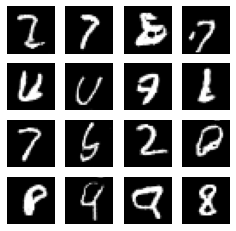

Time for interval 145 is 6.1955726146698 sec
14600 [D loss: -2238.189941, real_score: 2611.108398, fake_score: 372.918274 ] [G loss: 2222.197754]


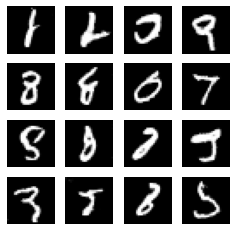

Time for interval 146 is 6.169752597808838 sec
14700 [D loss: -1688.253906, real_score: -346.644257, fake_score: -2034.898193 ] [G loss: 2012.089111]


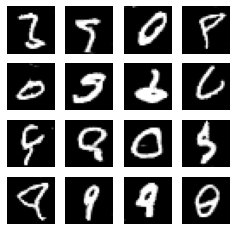

Time for interval 147 is 6.186146974563599 sec
14800 [D loss: -1923.994873, real_score: -888.204346, fake_score: -2812.199707 ] [G loss: 2694.906250]


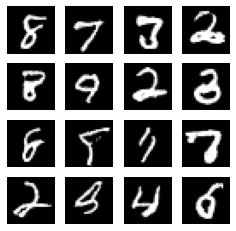

Time for interval 148 is 6.16715145111084 sec
14900 [D loss: -1667.076904, real_score: 48.180450, fake_score: -1618.896729 ] [G loss: 2218.712646]


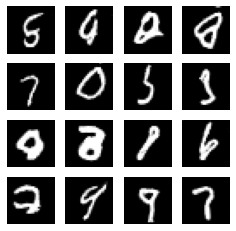

Time for interval 149 is 6.241544246673584 sec
15000 [D loss: -2172.626709, real_score: 280.279053, fake_score: -1892.347656 ] [G loss: 747.149475]


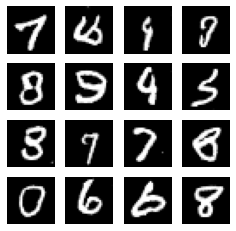

Time for interval 150 is 6.130551815032959 sec
15100 [D loss: -1889.457764, real_score: -1633.471069, fake_score: -3522.928711 ] [G loss: 3596.015625]


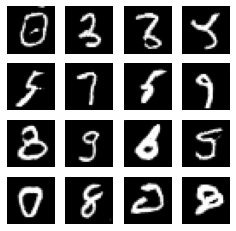

Time for interval 151 is 6.1157386302948 sec
15200 [D loss: -3162.788086, real_score: 1725.828857, fake_score: -1436.959473 ] [G loss: 2501.115723]


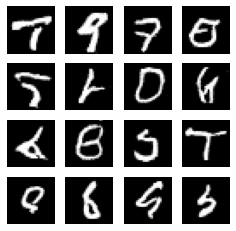

Time for interval 152 is 6.142255783081055 sec
15300 [D loss: -2920.752686, real_score: 1557.986328, fake_score: -1362.766357 ] [G loss: 1750.692017]


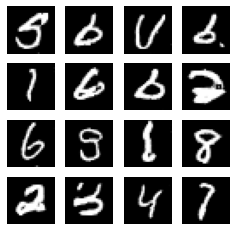

Time for interval 153 is 6.262740850448608 sec
15400 [D loss: -1590.056152, real_score: 1975.819336, fake_score: 385.763275 ] [G loss: 1738.043701]


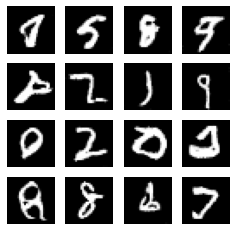

Time for interval 154 is 6.152468681335449 sec
15500 [D loss: -2564.436279, real_score: 862.587341, fake_score: -1701.848633 ] [G loss: 1894.889160]


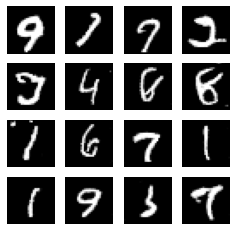

Time for interval 155 is 6.1675591468811035 sec
15600 [D loss: -2673.864502, real_score: -1129.261475, fake_score: -3803.125977 ] [G loss: 5464.535645]


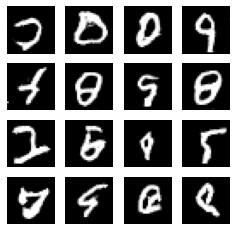

Time for interval 156 is 6.260741710662842 sec
15700 [D loss: -2098.564453, real_score: 3299.961426, fake_score: 1201.396851 ] [G loss: 2253.487793]


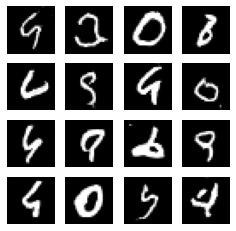

Time for interval 157 is 6.135339021682739 sec
15800 [D loss: -1421.718384, real_score: -423.498169, fake_score: -1845.216553 ] [G loss: 436.256897]


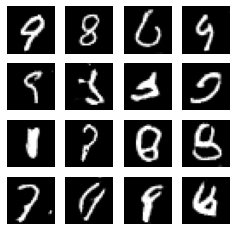

Time for interval 158 is 6.1729912757873535 sec
15900 [D loss: -1294.165894, real_score: -118.636398, fake_score: -1412.802368 ] [G loss: 59.077442]


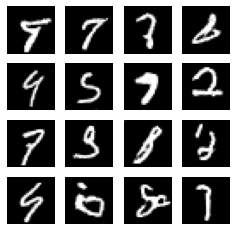

Time for interval 159 is 6.184102296829224 sec
16000 [D loss: -2622.982422, real_score: -2473.680664, fake_score: -5096.663086 ] [G loss: 1254.643921]


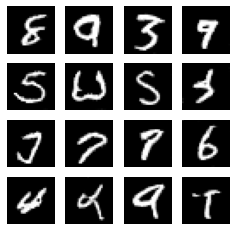

Time for interval 160 is 6.285941123962402 sec
16100 [D loss: -1175.056519, real_score: 1254.666870, fake_score: 79.610352 ] [G loss: 3100.057373]


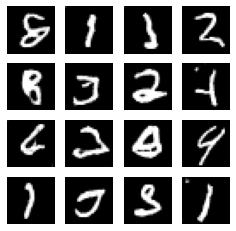

Time for interval 161 is 6.1265716552734375 sec
16200 [D loss: -2327.641602, real_score: -1877.416870, fake_score: -4205.058594 ] [G loss: 1875.276367]


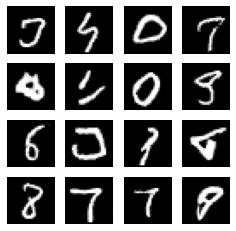

Time for interval 162 is 6.146010160446167 sec
16300 [D loss: -1619.360352, real_score: -2914.148682, fake_score: -4533.509277 ] [G loss: 4926.223633]


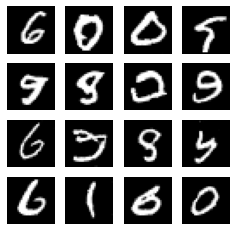

Time for interval 163 is 6.258413314819336 sec
16400 [D loss: -2127.243652, real_score: 2890.187500, fake_score: 762.943665 ] [G loss: 901.879761]


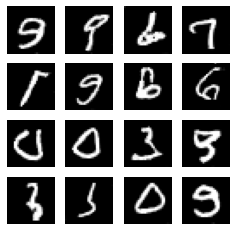

Time for interval 164 is 6.217918395996094 sec
16500 [D loss: -2468.444336, real_score: 2460.468018, fake_score: -7.976212 ] [G loss: 1501.918945]


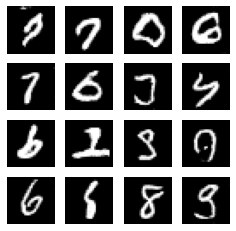

Time for interval 165 is 6.173441410064697 sec
16600 [D loss: -2003.325562, real_score: -197.294708, fake_score: -2200.620117 ] [G loss: 2136.372803]


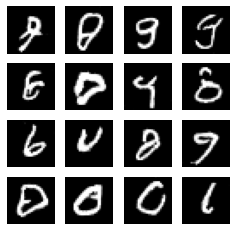

Time for interval 166 is 6.173205614089966 sec
16700 [D loss: -2753.719238, real_score: 386.292969, fake_score: -2367.426270 ] [G loss: 2742.750000]


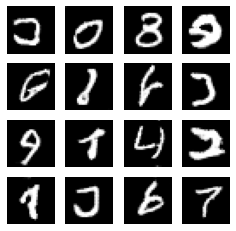

Time for interval 167 is 6.241925477981567 sec
16800 [D loss: -1800.760010, real_score: 2311.791992, fake_score: 511.031952 ] [G loss: -1445.315674]


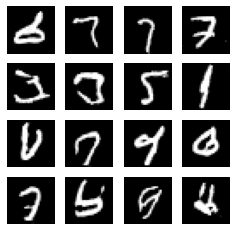

Time for interval 168 is 6.098478078842163 sec
16900 [D loss: -3350.198975, real_score: -2388.792969, fake_score: -5738.991211 ] [G loss: 2533.437744]


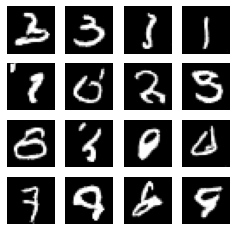

Time for interval 169 is 6.133121967315674 sec
17000 [D loss: -1681.371216, real_score: 2855.773926, fake_score: 1174.402832 ] [G loss: -1101.518555]


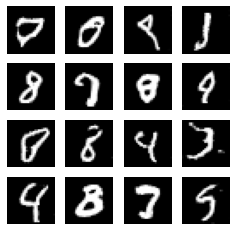

Time for interval 170 is 6.183462619781494 sec
17100 [D loss: -3552.147705, real_score: 602.085205, fake_score: -2950.062500 ] [G loss: 1706.829346]


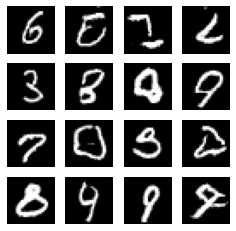

Time for interval 171 is 6.251714706420898 sec
17200 [D loss: -3667.810791, real_score: 554.438110, fake_score: -3113.372559 ] [G loss: 1832.548828]


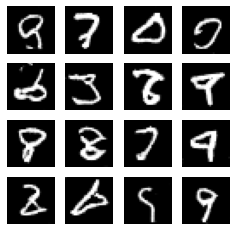

Time for interval 172 is 6.24665093421936 sec
17300 [D loss: -2148.717773, real_score: -3235.108887, fake_score: -5383.826660 ] [G loss: 223.676086]


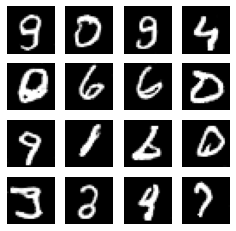

Time for interval 173 is 6.1482696533203125 sec
17400 [D loss: -3211.433105, real_score: -67.397141, fake_score: -3278.830078 ] [G loss: 4135.485352]


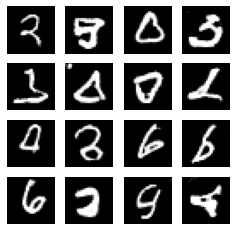

Time for interval 174 is 6.262730836868286 sec
17500 [D loss: -2253.135254, real_score: -70.432426, fake_score: -2323.567627 ] [G loss: 4484.599609]


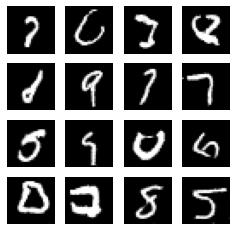

Time for interval 175 is 6.1628406047821045 sec
17600 [D loss: -3851.853027, real_score: 854.366638, fake_score: -2997.486084 ] [G loss: 3998.938232]


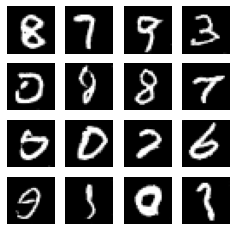

Time for interval 176 is 6.1503379344940186 sec
17700 [D loss: -2639.105713, real_score: -1551.911865, fake_score: -4191.018066 ] [G loss: 5004.928223]


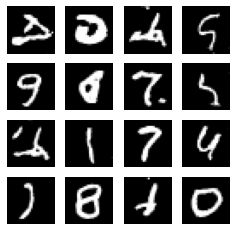

Time for interval 177 is 6.283910751342773 sec
17800 [D loss: -4000.390381, real_score: 4261.141113, fake_score: 260.751038 ] [G loss: 3222.698242]


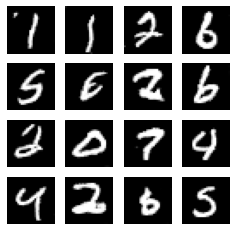

Time for interval 178 is 6.065852880477905 sec
17900 [D loss: -2829.393066, real_score: -181.925232, fake_score: -3011.318359 ] [G loss: -3127.136719]


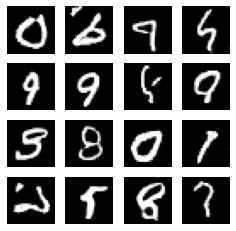

Time for interval 179 is 6.153987169265747 sec
18000 [D loss: -2336.996826, real_score: -5320.770508, fake_score: -7657.766602 ] [G loss: 3346.860840]


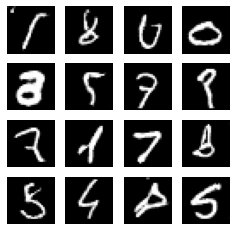

Time for interval 180 is 6.115323543548584 sec
18100 [D loss: -3100.594727, real_score: -1597.266724, fake_score: -4697.861816 ] [G loss: 5412.703613]


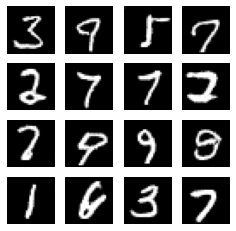

Time for interval 181 is 6.208009719848633 sec
18200 [D loss: -1884.999512, real_score: 146.901184, fake_score: -1738.098145 ] [G loss: 2045.947510]


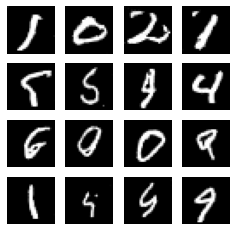

Time for interval 182 is 6.057680606842041 sec
18300 [D loss: -4087.522705, real_score: 1105.148438, fake_score: -2982.374268 ] [G loss: 636.783569]


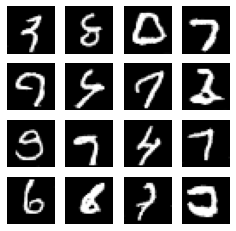

Time for interval 183 is 6.19577956199646 sec
18400 [D loss: -2734.200195, real_score: -778.451538, fake_score: -3512.651855 ] [G loss: 6210.572266]


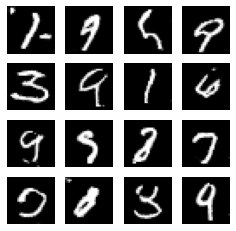

Time for interval 184 is 6.2246763706207275 sec
18500 [D loss: -3293.937988, real_score: 736.787598, fake_score: -2557.150635 ] [G loss: 5303.173828]


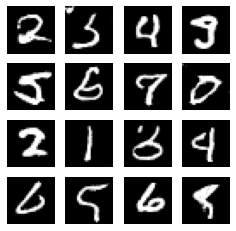

Time for interval 185 is 6.101381063461304 sec
18600 [D loss: -4761.033203, real_score: 177.435944, fake_score: -4583.597656 ] [G loss: 3859.572266]


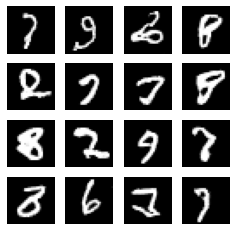

Time for interval 186 is 6.086333274841309 sec
18700 [D loss: -2080.619629, real_score: -1920.342896, fake_score: -4000.962158 ] [G loss: 6241.661133]


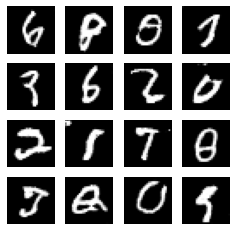

Time for interval 187 is 6.081753969192505 sec
18800 [D loss: -3100.977539, real_score: -526.845947, fake_score: -3627.823242 ] [G loss: 1863.134888]


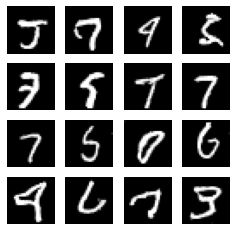

Time for interval 188 is 6.228842735290527 sec
18900 [D loss: -3088.250000, real_score: -303.897766, fake_score: -3392.147949 ] [G loss: 3281.073975]


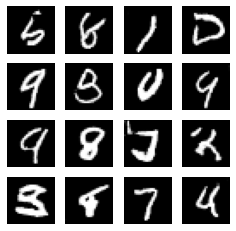

Time for interval 189 is 6.114909648895264 sec
19000 [D loss: -3521.098633, real_score: 2315.165527, fake_score: -1205.933716 ] [G loss: 2165.244385]


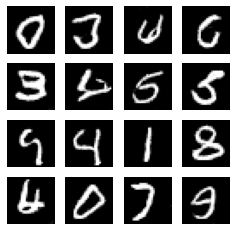

Time for interval 190 is 6.056476354598999 sec
19100 [D loss: -2897.956787, real_score: 3601.942383, fake_score: 703.985718 ] [G loss: 57.806366]


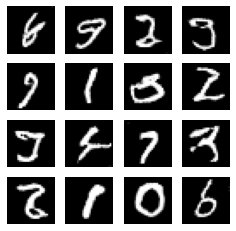

Time for interval 191 is 6.229130744934082 sec
19200 [D loss: -1321.008789, real_score: -4318.846680, fake_score: -5639.855469 ] [G loss: 7114.571289]


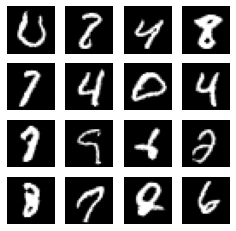

Time for interval 192 is 6.09482479095459 sec
19300 [D loss: -1680.037598, real_score: 3306.106689, fake_score: 1626.069336 ] [G loss: 3956.256348]


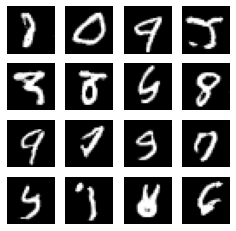

Time for interval 193 is 6.163090705871582 sec
19400 [D loss: -3361.497803, real_score: -822.120972, fake_score: -4183.618652 ] [G loss: 3575.981934]


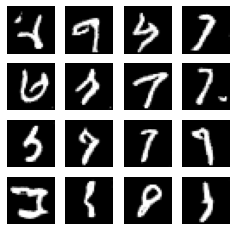

Time for interval 194 is 6.117858409881592 sec
19500 [D loss: -3812.927246, real_score: 3233.410889, fake_score: -579.516357 ] [G loss: 1226.995361]


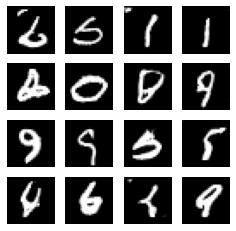

Time for interval 195 is 6.236520528793335 sec
19600 [D loss: -2839.370850, real_score: -533.833496, fake_score: -3373.204346 ] [G loss: 3269.916504]


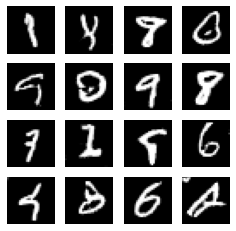

Time for interval 196 is 6.109896183013916 sec
19700 [D loss: -1489.088501, real_score: 413.463745, fake_score: -1075.624756 ] [G loss: 4384.075684]


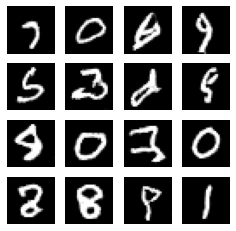

Time for interval 197 is 6.069208383560181 sec
19800 [D loss: -2540.588379, real_score: -2474.463623, fake_score: -5015.051758 ] [G loss: 5977.770020]


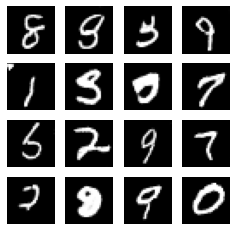

Time for interval 198 is 6.186494827270508 sec
19900 [D loss: -968.383301, real_score: 1035.532837, fake_score: 67.149475 ] [G loss: 4567.032715]


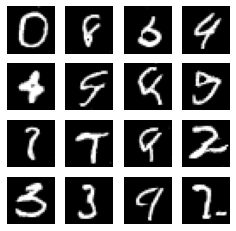

Time for interval 199 is 6.091406583786011 sec
20000 [D loss: -2935.118164, real_score: -1407.934082, fake_score: -4343.052246 ] [G loss: 499.230133]


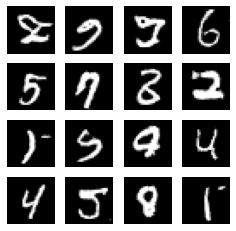

Time for interval 200 is 6.136197805404663 sec


In [13]:
# Set hyperparameters
iterations = 20000
batch_size = 128
sample_interval = 100
# Build models
# Train the GAN for the specified number of iterations
train(iterations, batch_size, sample_interval,use_tf2=use_tf2)

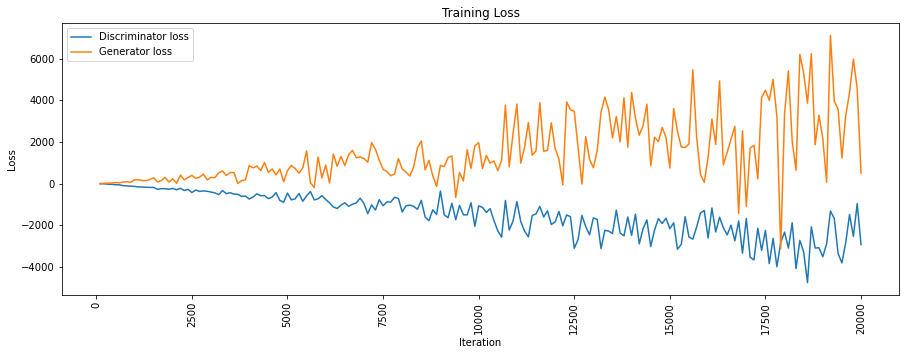

In [14]:
losses = np.array(losses)
# print(iteration_checkpoints)
# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, losses.T[0], label="Discriminator loss")
plt.plot(iteration_checkpoints, losses.T[1], label="Generator loss")

plt.xticks(rotation=90)

plt.title("Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()

----

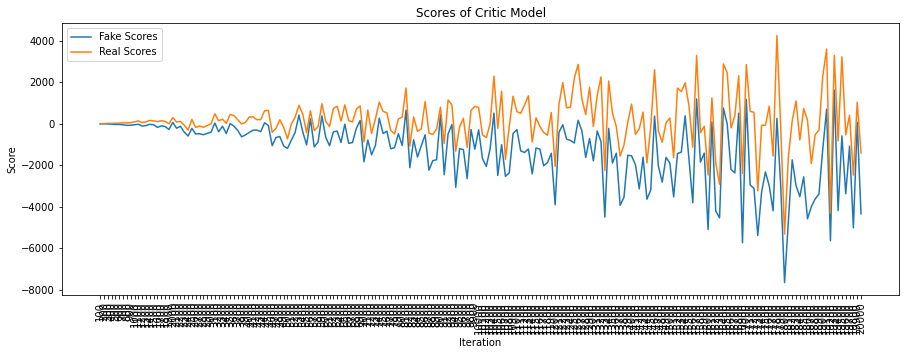

In [15]:
f_scores = np.array(f_scores)
r_scores = np.array(r_scores)

# Plot training losses for Discriminator and Generator
plt.figure(figsize=(15, 5))
plt.plot(iteration_checkpoints, f_scores, label="Fake Scores")
plt.plot(iteration_checkpoints, r_scores, label="Real Scores")

plt.xticks(iteration_checkpoints, rotation=90)

plt.title("Scores of Critic Model")
plt.xlabel("Iteration")
plt.ylabel("Score")
plt.legend()

100
[87 13 28 52  3 52 60 88 11 76]
tf.Tensor([[19619.568]], shape=(1, 1), dtype=float32)


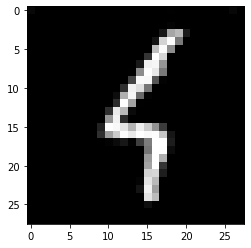

tf.Tensor([[6981.678]], shape=(1, 1), dtype=float32)


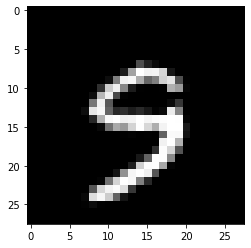

tf.Tensor([[10824.891]], shape=(1, 1), dtype=float32)


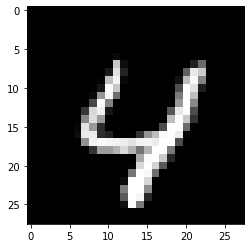

tf.Tensor([[14885.275]], shape=(1, 1), dtype=float32)


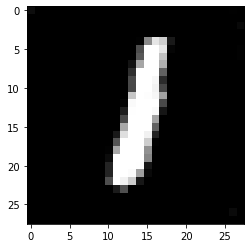

tf.Tensor([[-2342.0166]], shape=(1, 1), dtype=float32)


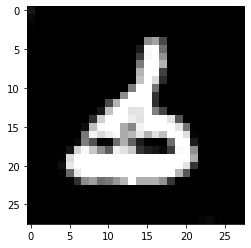

tf.Tensor([[14885.275]], shape=(1, 1), dtype=float32)


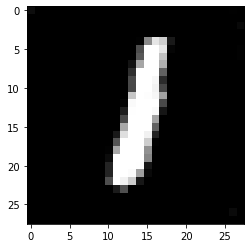

tf.Tensor([[6145.6323]], shape=(1, 1), dtype=float32)


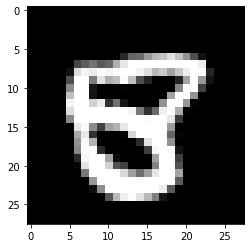

tf.Tensor([[13093.953]], shape=(1, 1), dtype=float32)


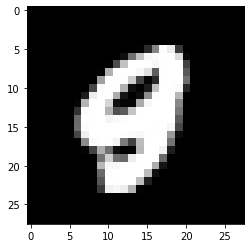

tf.Tensor([[11326.318]], shape=(1, 1), dtype=float32)


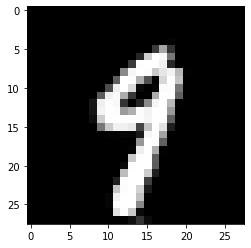

tf.Tensor([[6110.5835]], shape=(1, 1), dtype=float32)


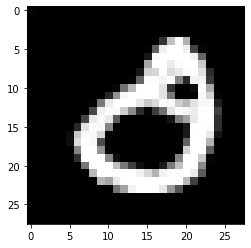

In [16]:
def evaluate(n_sample=100, use_tf2=False):
    # Generate a batch of fake images
    z = np.random.normal(0, 1, (n_sample, 100))
    # Train Discriminator
    if use_tf2:
        gen_imgs = generator(z)
    else: 
        gen_imgs = generator.predict(z)

    idx = np.random.randint(0, gen_imgs.shape[0], 10 )
    print(gen_imgs.shape[0])
    print(idx)
    for i in idx:
      sel_imgs=gen_imgs[i,:,:,0]
      print(discriminator(gen_imgs[i:i+1]))
      plt.imshow(sel_imgs,cmap='gray')
      plt.show()
    
evaluate(n_sample=100,use_tf2=use_tf2)